In [1]:
from mpl_toolkits import mplot3d
# %matplotlib inline
%matplotlib notebook
import numpy as np
import os
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
root_dir = '/home/elodie/KITTI_DATASET/object/training'
label_dir = '/home/elodie/Det3D'
example_id = '000001'
raw_lidar = np.fromfile(os.path.join(root_dir, 'velodyne/'+example_id+'.bin'), dtype=np.float32).reshape((-1,4))

labels = os.path.join(label_dir, 'predictions', example_id+'.txt') #predict
calib_labels = os.path.join(root_dir, 'label_2', example_id+'.txt')

#雷达到相机的转换
calib_file = os.path.join(root_dir, 'calib', example_id+'.txt')
# raw_lidar = np.fromfile("/home/users/benjin.zhu/1542617253237.bin", dtype=np.float32).reshape(-1, 4)

In [3]:
raw_lidar.shape

(120268, 4)

In [4]:
xdata = raw_lidar[:,0]
ydata = raw_lidar[:,1]
zdata = raw_lidar[:,2]
idata = raw_lidar[:,3]

<IPython.core.display.Javascript object>


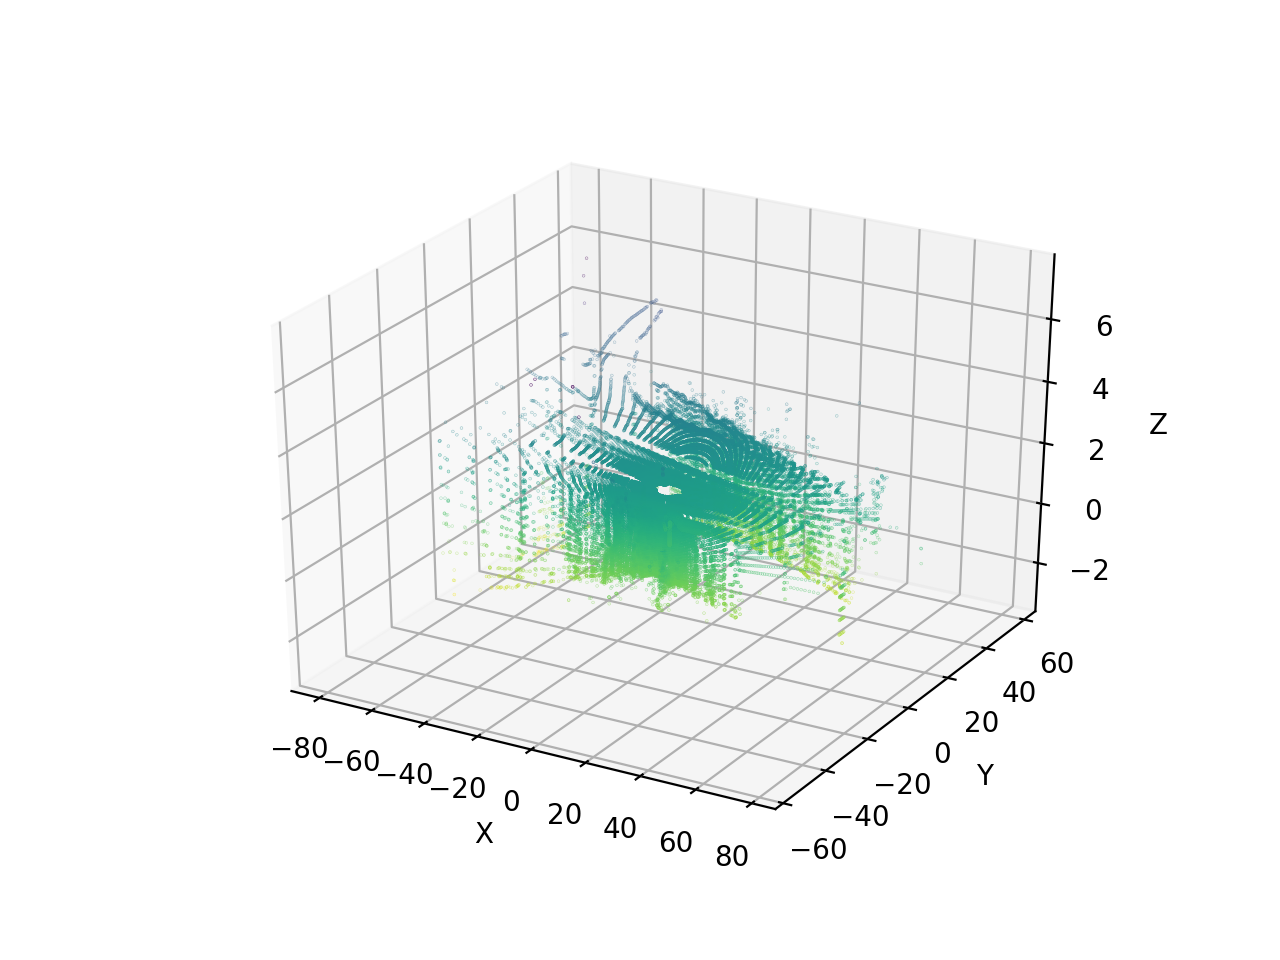

Text(0.5, 0, 'Z')

In [5]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(xdata, ydata, -zdata, c=zdata, marker='.', s=0.1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.view_init(,45)

In [6]:
def load_calibration(calib_file):
    calib = [x.strip().split() for x in open(calib_file).readlines()]
    P0 = np.array([float(i) for i in calib[0][1:]]).reshape((3,4))
    P1 = np.array([float(i) for i in calib[1][1:]]).reshape((3,4))
    P2 = np.array([float(i) for i in calib[2][1:]]).reshape((3,4))
    P3 = np.array([float(i) for i in calib[3][1:]]).reshape((3,4))
    R0_rect = np.eye(4, dtype='float32')
    R0_3x3 = np.array([float(i) for i in calib[4][1:]]).reshape((3,3))
    R0_rect[:3,:3] = R0_3x3
    T_v2c = np.eye(4, dtype='float32')
    T_v2c[:3,:] = np.array([float(i) for i in calib[5][1:]]).reshape((3,4))
    T_vel_to_cam = np.dot(R0_rect, T_v2c)
    
    calibs = {'P0': P0, 'P1': P1, 'P2': P2,'P3': P3,
                'R0_rect': R0_rect,
                'T_v2c': T_v2c, 'T_vel_to_cam': T_vel_to_cam}
    return calibs

# def load_calibration(calib_file):
#     calib = [x.strip().split() for x in open(calib_file).readlines()]

#     P1 = np.array(list(map(float, calib[0][1:]))).reshape((3, 4))
#     R1_3x3 = np.array(list(map(float, calib[1][1:]))).reshape((3, 3))
#     R = np.array(list(map(float, calib[2][1:]))).reshape((3, 3))
#     t = np.array(list(map(float, calib[3][1:]))).reshape((1, 3))

#     R1_rect = np.eye(4, dtype='float32')
#     R1_rect[:3, :3] = R1_3x3

#     T_v2c = np.eye(4, dtype='float32')
#     T_v2c[:3, :3] = R
#     T_v2c[:3, 3] = t
#     T_vel_to_cam = np.dot(R1_rect, T_v2c)

#     calibs = {
#         'P1': P1,
#         'R1_rect': R1_rect,
#         'R': R,
#         't': t,
#         'T_v2c': T_v2c,
#         'T_vel_to_cam': T_vel_to_cam
#     }
#     return calibs

In [7]:
calibs = load_calibration(calib_file)
type(calibs['P1'])

numpy.ndarray

In [8]:
# def label_to_bbox3d(labels):
#     N = len(labels)
#     ret = np.zeros((N, 8, 3), dtype=np.float32)
    
#     for i in range(N):
#         box = labels[i]
#         translation = box[4:7]
#         [l, w, h] = box[1:4]
#         rotation = [0, 0, box[-1]]
#         trackletBox = np.array([  # in velodyne coordinates around zero point and without orientation yet
#             [l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2],
#             [w/2, -w/2,-w/2, w/2,  w/2, -w/2,-w/2, w/2],
#             [h/2, h/2, h/2,  h/2,  -h/2,-h/2,-h/2, -h/2]
#         ])

#         # re-create 3D bounding box in velodyne coordinate system
#         yaw = rotation[2]
                
#         rotMat = np.array([
#             [np.cos(yaw),  np.sin(yaw), 0], 
#             [-np.sin(yaw),  np.cos(yaw), 0],
#             [0,            0,           1]
#         ])
        
#         cornerPosInVelo = np.dot(trackletBox.T, rotMat) + np.tile(translation, (8, 1))
# #         box3d = cornerPosInVelo.transpose()
                
#         ret[i] = cornerPosInVelo
#     return ret

def label_to_bbox3d(labels):
    N = len(labels)
    ret = np.zeros((N, 8, 3), dtype=np.float32)
    
    for i in range(N):
        box = labels[i]
        translation = box[4:7]
        [h, w, l] = box[1:4]
        rotation = [0, 0, box[-1]]
        trackletBox = np.array([  # in velodyne coordinates around zero point and without orientation yet
            [l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2], \
            [0,0,0,0,-h,-h,-h,-h], \
            [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]])

        # re-create 3D bounding box in velodyne coordinate system
        yaw = rotation[2]
        rotMat = np.array([[np.cos(yaw), 0, np.sin(yaw)],
                          [0, 1, 0], 
                          [-np.sin(yaw), 0, np.cos(yaw)]])
        cornerPosInVelo = np.dot(rotMat, trackletBox) + \
            np.tile(translation, (8, 1)).T
        box3d = cornerPosInVelo.transpose()
        ret[i] = box3d
    return ret

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

colors = {
    'Car': 'b',
    'Tram': 'r',
    'Cyclist': 'g',
    'Van': 'c',
    'Truck': 'm',
    'Pedestrian': 'y',
    'Sitter': 'k'
}
axes_limits = [
    [-70.4, 70.4], # X axis range
    [-40, 40], # Y axis range
    [-10, 10]   # Z axis range
]
axes_str = ['X', 'Y', 'Z']

def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black'):
    """
    Draws a bounding 3D box in a pyplot axis.
    
    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = np.transpose(vertices)[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=0.5)


In [10]:
def display_single_lidar(data, boxes=None, points=0.2, view=False):
    # points          : Fraction of lidar points to use. Defaults to `0.2`, e.g. 20%.

    points_step = int(1. / points)
    point_size = 0.01 * (1. / points)
    velo_range = range(0, data.shape[0], points_step)
    
    print(points_step)
    print(point_size)
    print(velo_range)

    def draw_point_cloud(ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None):
        """
        Convenient method for drawing various point cloud projections as a part of frame statistics.
        """
        ax.scatter(*np.transpose(data[:, axes]), s=point_size, c=data[:, 3], cmap='gray')
        
        ax.set_title(title)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
        if len(axes) > 2:
            ax.set_xlim3d(*axes_limits[axes[0]])
            ax.set_ylim3d(*axes_limits[axes[1]])
            ax.set_zlim3d(*axes_limits[axes[2]])
            ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
        else:
            ax.set_xlim(*axes_limits[axes[0]])
            ax.set_ylim(*axes_limits[axes[1]])
        
        # User specified limits
        if xlim3d!=None:
            ax.set_xlim3d(xlim3d)
        if ylim3d!=None:
            ax.set_ylim3d(ylim3d)
        if zlim3d!=None:
            ax.set_zlim3d(zlim3d)
        
        for i in range(boxes.shape[0]):
            draw_box(ax, boxes[i], axes=axes, color='green')
            
    # Draw point cloud data as 3D plot
    f2 = plt.figure(figsize=(10, 5))
    ax2 = f2.add_subplot(111, projection='3d')   
    ax2.view_init(45,45)
    
    # Hide grid lines
    ax2.grid(False)
#     plt.axis('off')
    
    draw_point_cloud(ax2, 'Velodyne scan', xlim3d=axes_limits[0])
    plt.show()
    
    if view:    
        # Draw point cloud data as plane projections
        f, ax3 = plt.subplots(3, 1, figsize=(15, 25))
#         axe3.view_init(35,100)
        draw_point_cloud(
            ax3[0], 
            'Velodyne scan, XZ projection (Y = 0), the car is moving in direction left to right', 
            axes=[0, 2] # X and Z axes
        )
        draw_point_cloud(
            ax3[1], 
            'Velodyne scan, XY projection (Z = 0), the car is moving in direction left to right', 
            axes=[0, 1] # X and Y axes
        )
        draw_point_cloud(
            ax3[2], 
            'Velodyne scan, YZ projection (X = 0), the car is moving towards the graph plane', 
            axes=[1, 2] # Y and Z axes
        )
        plt.show()

In [11]:
pos_cls = ['Car']
ign_cls = ['Van', 'Truck', 'Tram']

In [12]:
def parse_label(labels):
    with open(labels, 'r') as fin:
        ret = []
        for line in fin.readlines():
            line = line.split(' ')# elodie
            [cls, truncated, occluded, alpha, lt_x, lt_y, rb_x, rb_y, h, w, l, x, y, z, rotation_y] = line[:15]# elodie
            #[cls, truncated, occluded, alpha, lt_x, lt_y, rb_x, rb_y, h, w, l, x, y, z, rotation_y] = line.split(' ') # elodie
            # if cls in pos_cls: # or  cls in ign_cls
            ret.append([cls, float(h), float(w), float(l), float(x), float(y), float(z), float(rotation_y)])
        return ret

lbl = parse_label(labels)
print(lbl)


[['Car', 1.4669, 1.5551, 3.61, 7.1154, 1.599, 29.2719, -1.397], ['Car', 1.4677, 1.5546, 3.7767, -16.6025, 2.3364, 58.4039, 1.4729]]


In [13]:
bbox3d = label_to_bbox3d(lbl)

In [14]:
def project_camera2velo(vel_data_c, calibs):
    # vel_data_c: col 0: back -> front
    #             col 1: down -> up
    #             col 2: left -> right
    
    vel_data = np.hstack((vel_data_c[:, :3], np.ones((vel_data_c.shape[0], 1), dtype='float32')))
    vel_data = np.dot(vel_data, np.linalg.inv(calibs['T_vel_to_cam'].T))
    # vel_data /= vel_data[:, -1].reshape((-1, 1))
    # vel_data = np.hstack((vel_data[:, :3], vel_data_c[:, -1].reshape((-1, 1))))

    return vel_data[:, :3]

In [15]:
bbox3d_lidar = []
#print("bbox3d:",bbox3d) 
for box in bbox3d:
    box = project_camera2velo(box, calibs)
    bbox3d_lidar.append(box)

bbox3d: [[[  6.661689   1.599     31.184164]
  [  8.193362   1.599     30.915253]
  [  7.569111   1.599     27.359636]
  [  6.037438   1.599     27.628548]
  [  6.661689   0.1321    31.184164]
  [  8.193362   0.1321    30.915253]
  [  7.569111   0.1321    27.359636]
  [  6.037438   0.1321    27.628548]]

 [[-15.644354   2.3364    56.600563]
  [-17.191511   2.3364    56.44862 ]
  [-17.560646   2.3364    60.207233]
  [-16.013489   2.3364    60.35918 ]
  [-15.644354   0.8687    56.600563]
  [-17.191511   0.8687    56.44862 ]
  [-17.560646   0.8687    60.207233]
  [-16.013489   0.8687    60.35918 ]]]


In [16]:
bbox3d_lidar = np.array(bbox3d_lidar)
bbox3d_lidar.shape

(2, 8, 3)

In [17]:
# def label_to_bbox3d(labels):
#     N = len(labels)
#     ret = np.zeros((N, 8, 3), dtype=np.float32)
    
#     for i in range(N):
#         box = labels[i]
#         translation = box[4:7]
#         size = box[1:4]
#         rotation = [0, 0, box[-1]]
#         h, w, l = size[0], size[1], size[2]
#         trackletBox = np.array([  # in velodyne coordinates around zero point and without orientation yet
#             [-l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2], \
#             [-w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2], \
#             [0, 0, 0, 0, -h, -h, -h, -h]])

#         # re-create 3D bounding box in velodyne coordinate system
#         yaw = rotation[2]
#         rotMat = np.array([[np.cos(yaw), np.sin(yaw), 0.0],
#                            [-np.sin(yaw), np.cos(yaw), 0.0], [0.0, 0.0, 1.0]])
#         cornerPosInVelo = np.dot(rotMat, trackletBox) + \
#             np.tile(translation, (8, 1)).T
#         box3d = cornerPosInVelo.transpose()
#         ret[i] = box3d
#     return ret


In [18]:
# bbox3d = label_to_bbox3d(lbl)

100
1.0
range(0, 120268, 100)


<IPython.core.display.Javascript object>


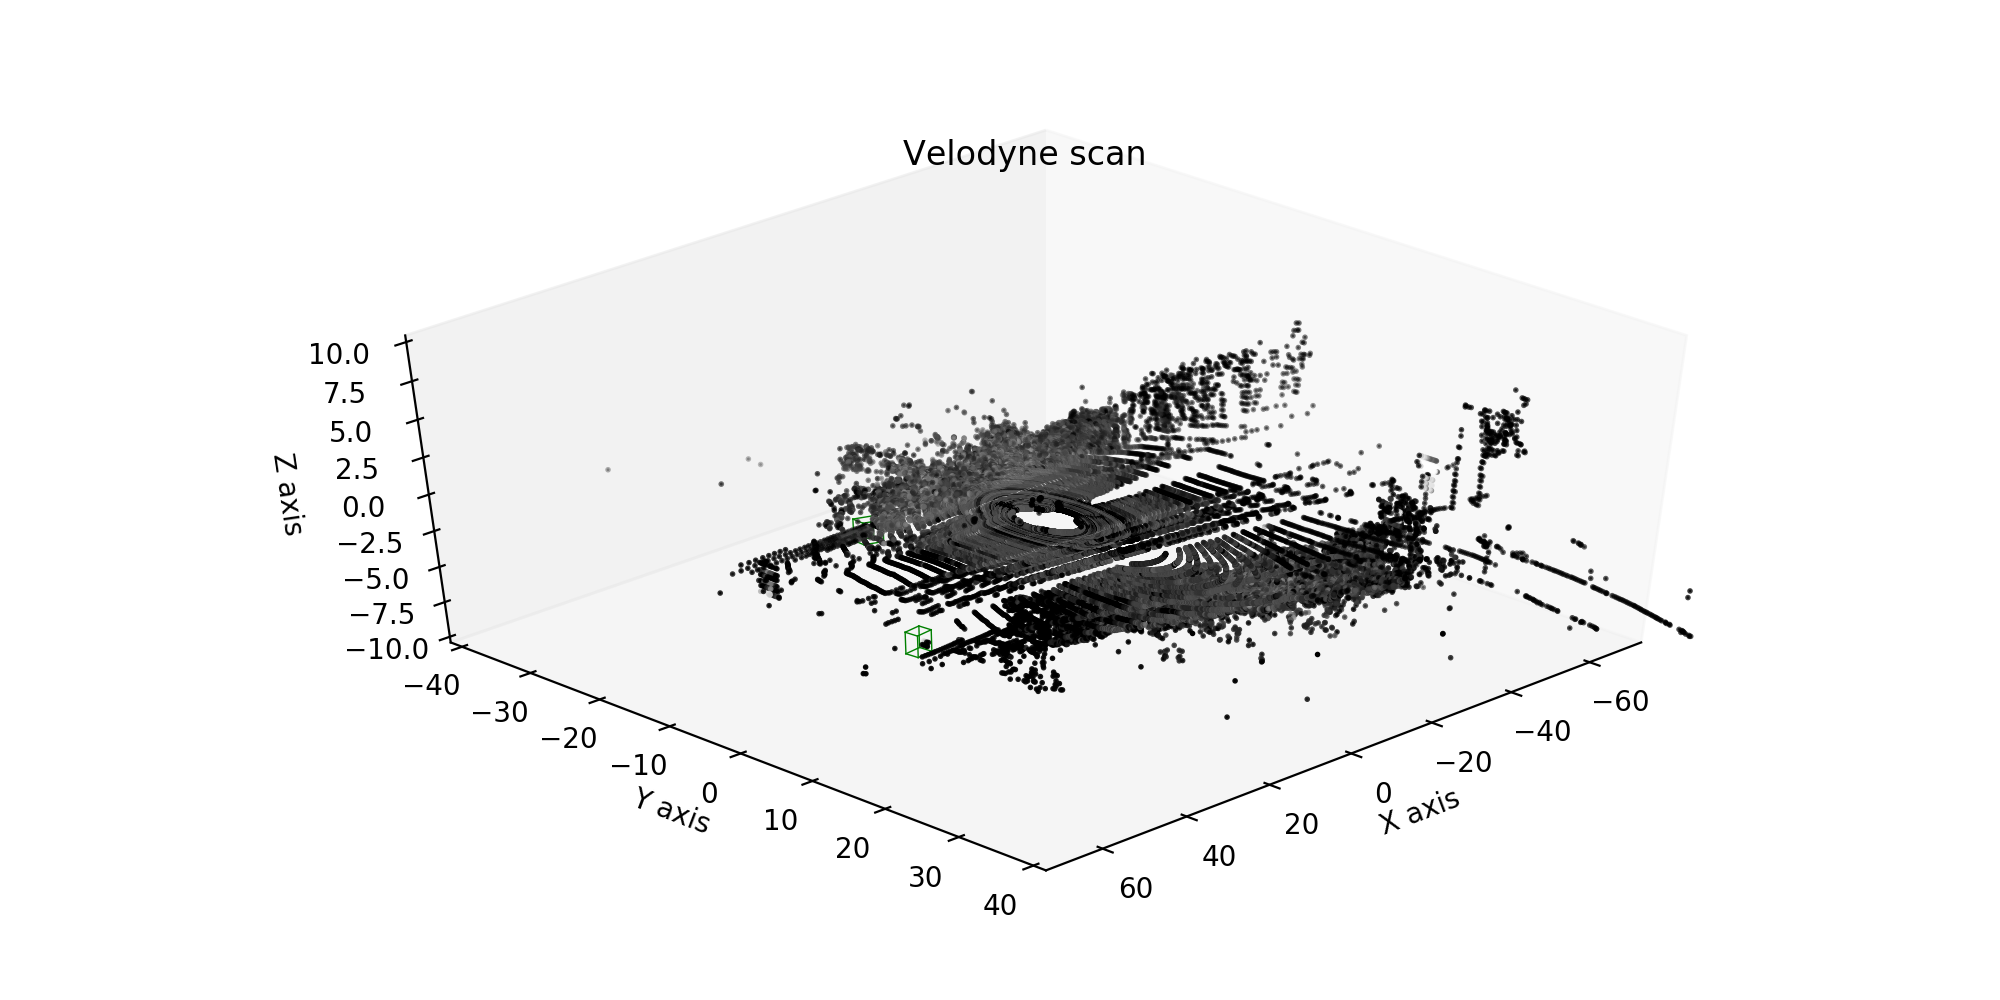

<IPython.core.display.Javascript object>


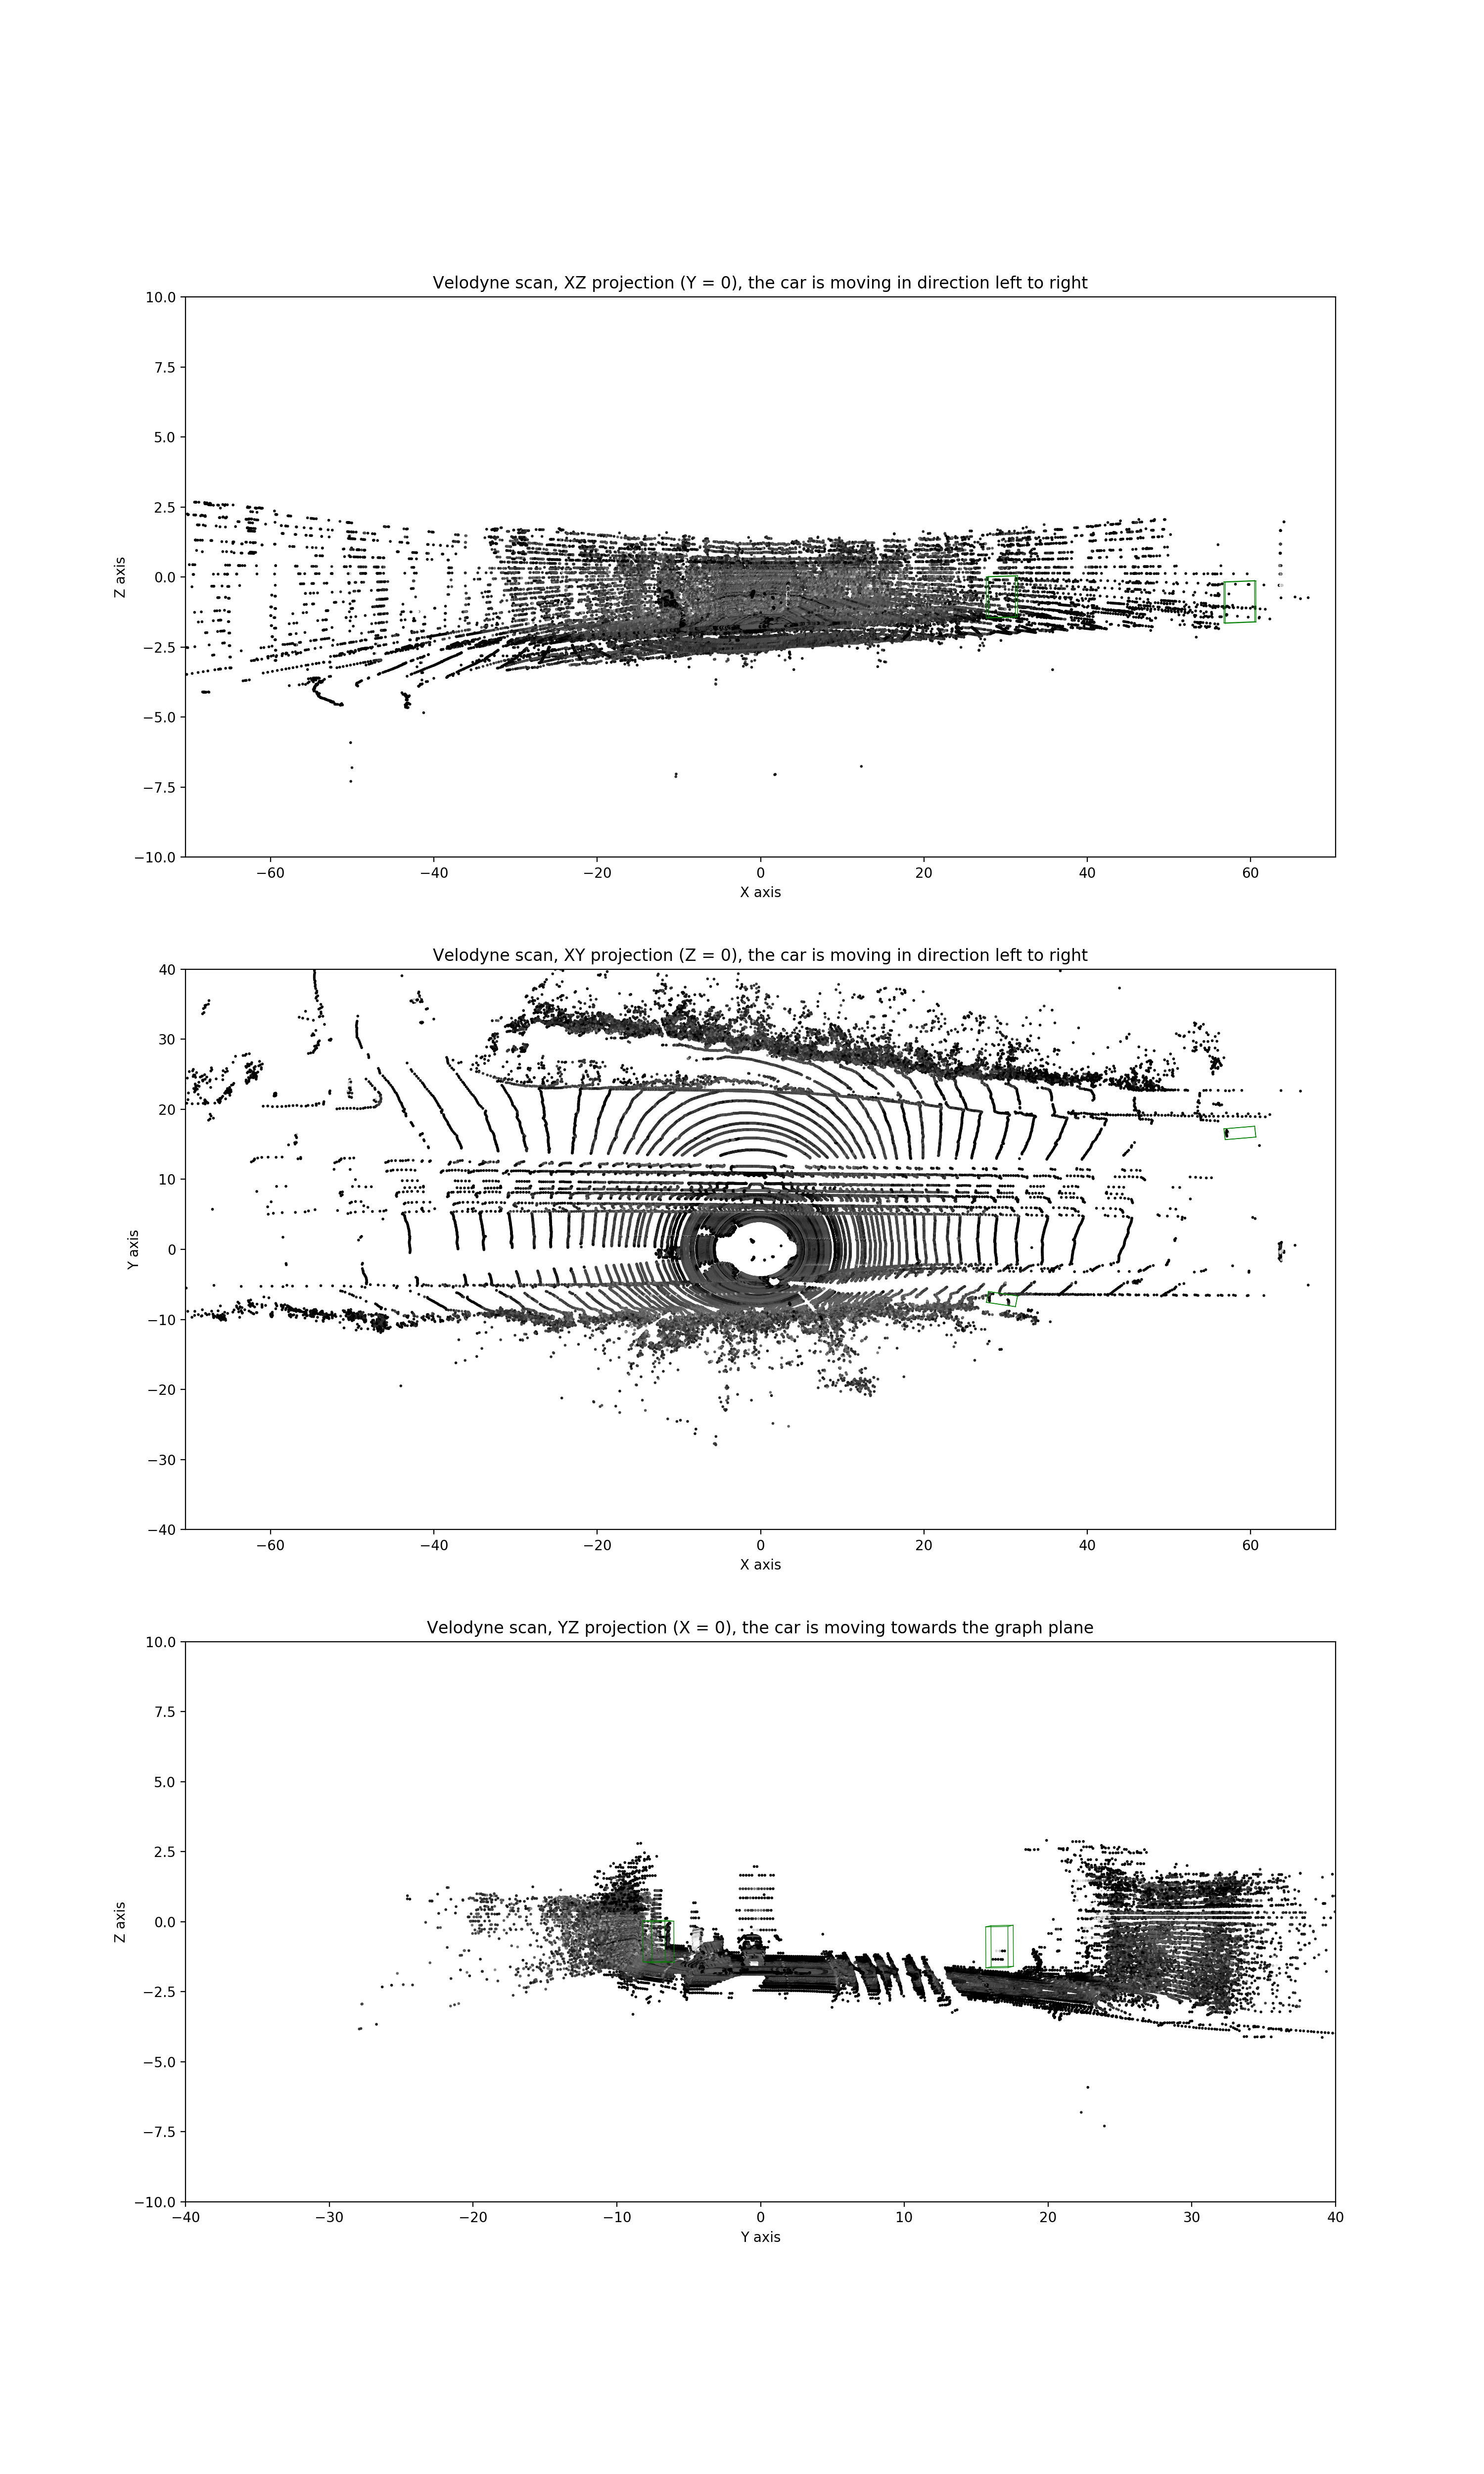

In [19]:
display_single_lidar(raw_lidar, bbox3d_lidar, points=.01, view=True)

calib_bbox3d: [[[-7.7831131e-01  1.4900000e+00  7.5623840e+01]
  [ 1.8515354e+00  1.4900000e+00  7.5595444e+01]
  [ 1.7183113e+00  1.4900000e+00  6.3256165e+01]
  [-9.1153538e-01  1.4900000e+00  6.3284557e+01]
  [-7.7831131e-01 -1.3600000e+00  7.5623840e+01]
  [ 1.8515354e+00 -1.3600000e+00  7.5595444e+01]
  [ 1.7183113e+00 -1.3600000e+00  6.3256165e+01]
  [-9.1153538e-01 -1.3600000e+00  6.3284557e+01]]

 [[-1.5593531e+01  2.3900001e+00  5.6645744e+01]
  [-1.7463530e+01  2.3900001e+00  5.6644257e+01]
  [-1.7466469e+01  2.3900001e+00  6.0334255e+01]
  [-1.5596470e+01  2.3900001e+00  6.0335743e+01]
  [-1.5593531e+01  7.2000003e-01  5.6645744e+01]
  [-1.7463530e+01  7.2000003e-01  5.6644257e+01]
  [-1.7466469e+01  7.2000003e-01  6.0334255e+01]
  [-1.5596470e+01  7.2000003e-01  6.0335743e+01]]

 [[ 4.3110676e+00  1.3200001e+00  4.6856022e+01]
  [ 4.9109378e+00  1.3200001e+00  4.6843544e+01]
  [ 4.8689322e+00  1.3200001e+00  4.4823978e+01]
  [ 4.2690620e+00  1.3200001e+00  4.4836456e+01]
  

<IPython.core.display.Javascript object>


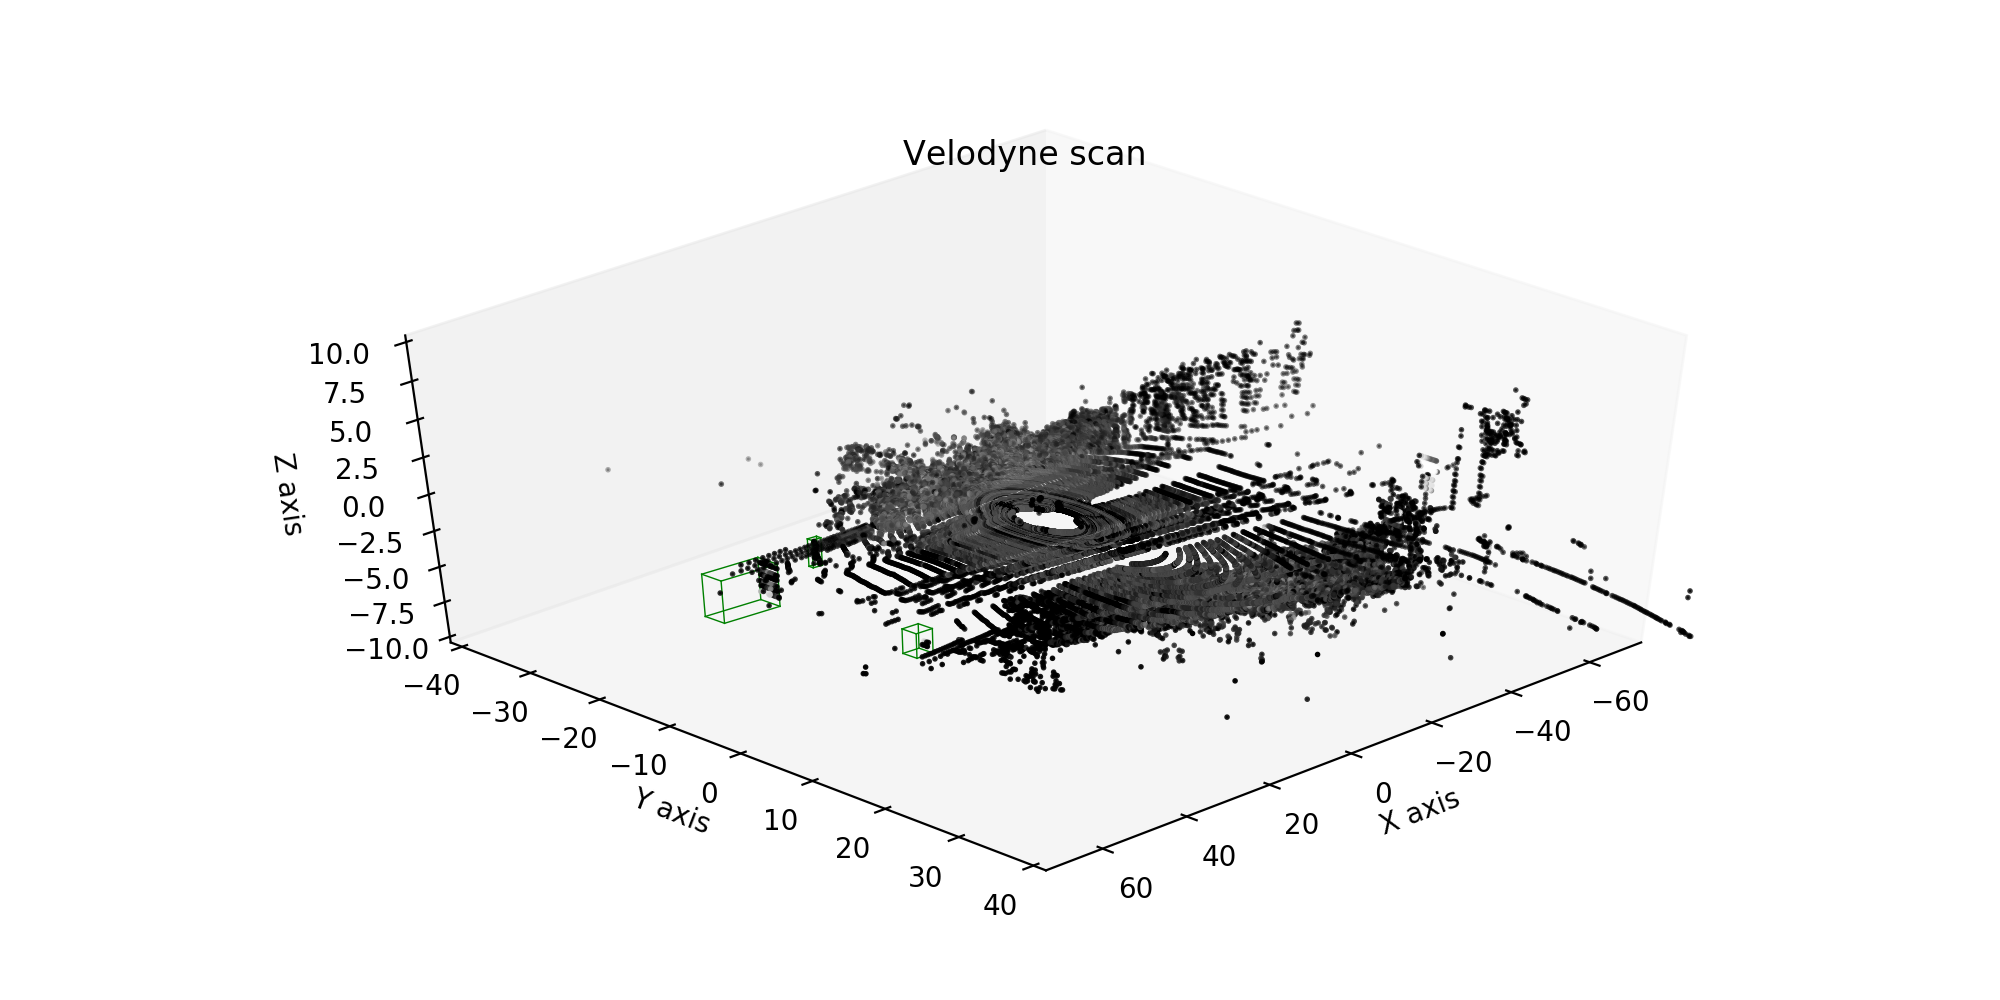

<IPython.core.display.Javascript object>


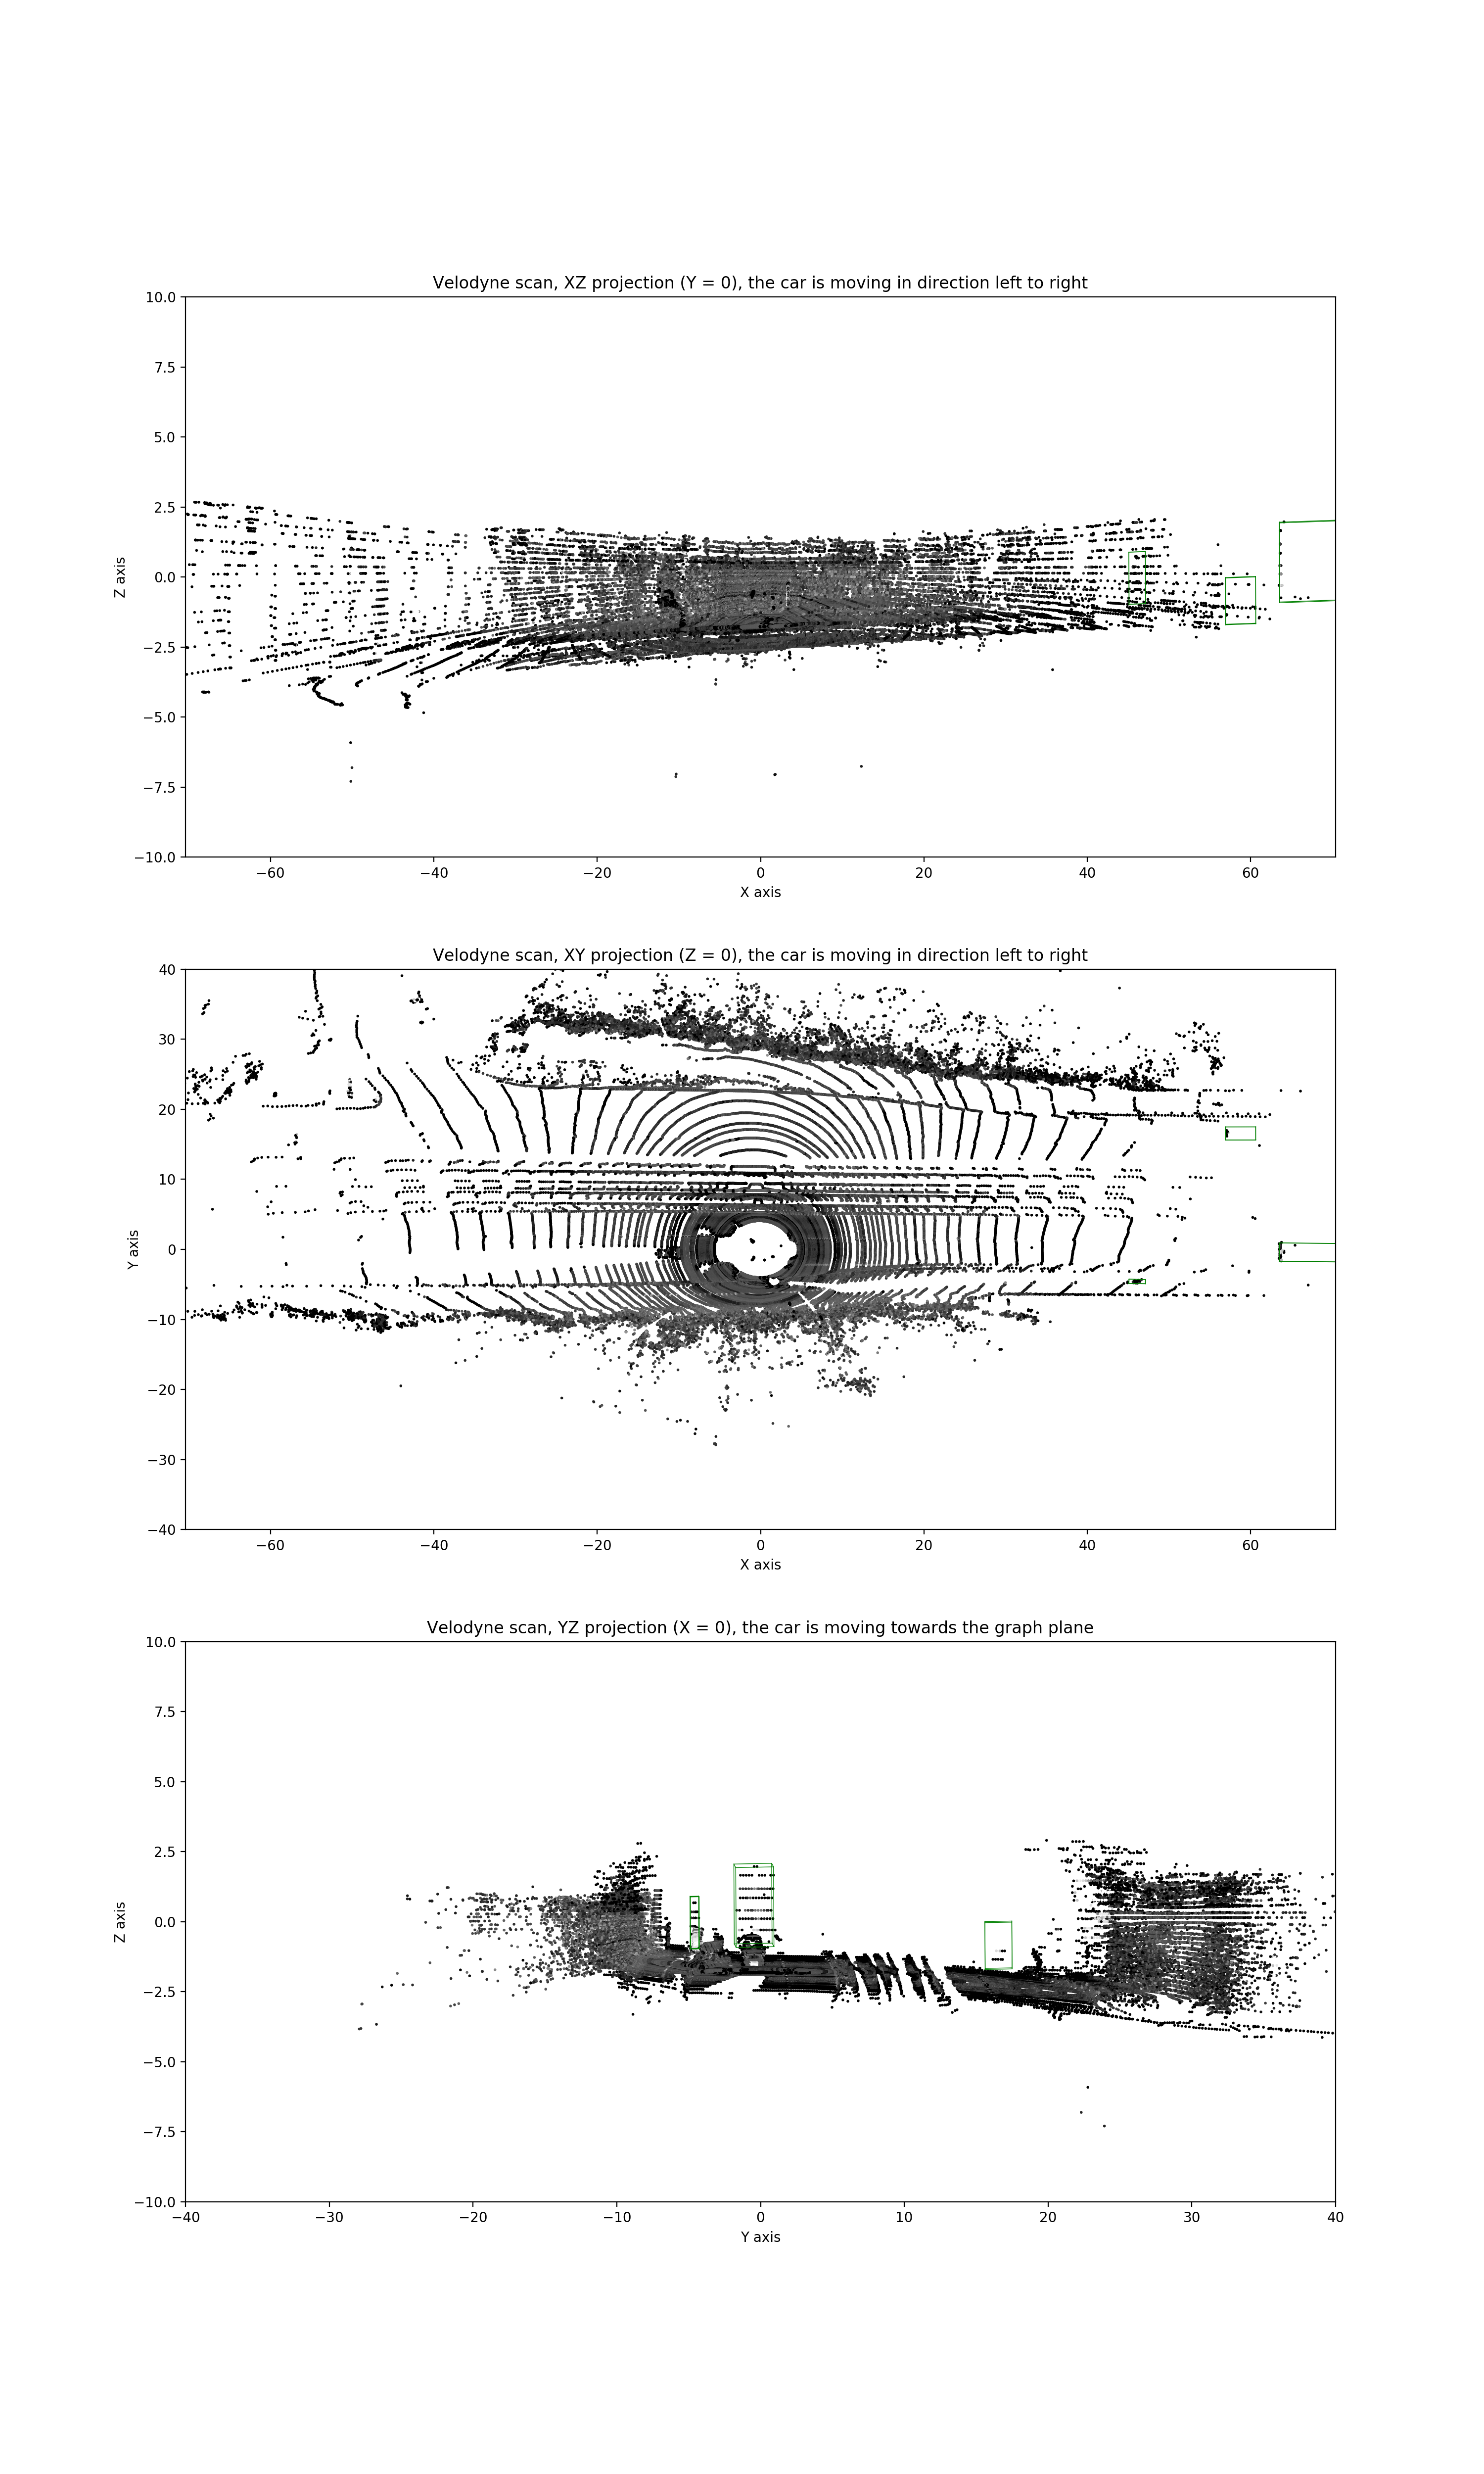

In [20]:
#绘制标注box calib
calib_lbl = parse_label(calib_labels)
calib_bbox3d = label_to_bbox3d(calib_lbl)
calib_bbox3d_lidar = []
for box in calib_bbox3d:
    box = project_camera2velo(box, calibs)
    calib_bbox3d_lidar.append(box)
calib_bbox3d_lidar = np.array(calib_bbox3d_lidar)
calib_bbox3d_lidar.shape
display_single_lidar(raw_lidar, calib_bbox3d_lidar, points=.01, view=True)

In [21]:
CORNER2CENTER_AVG = False
import math

def corner_to_center_box3d(boxes_corner):
    # (N, 8, 3) -> (N, 7) x,y,z,h,w,l,ry/z
    ret = []
    boxes_corner = boxes_corner[:, :, [1, 2, 0]] #更换列顺序1，2，0
    for roi in boxes_corner:
        print("roi:",roi)
        if CORNER2CENTER_AVG:  # average version
            roi = np.array(roi)
            h = abs(np.sum(roi[:4, 1] - roi[4:, 1]) / 4)
            w = np.sum(
                np.sqrt(np.sum((roi[0, [0, 2]] - roi[3, [0, 2]])**2)) +
                np.sqrt(np.sum((roi[1, [0, 2]] - roi[2, [0, 2]])**2)) +
                np.sqrt(np.sum((roi[4, [0, 2]] - roi[7, [0, 2]])**2)) +
                np.sqrt(np.sum((roi[5, [0, 2]] - roi[6, [0, 2]])**2))) / 4
            l = np.sum(
                np.sqrt(np.sum((roi[0, [0, 2]] - roi[1, [0, 2]])**2)) +
                np.sqrt(np.sum((roi[2, [0, 2]] - roi[3, [0, 2]])**2)) +
                np.sqrt(np.sum((roi[4, [0, 2]] - roi[5, [0, 2]])**2)) +
                np.sqrt(np.sum((roi[6, [0, 2]] - roi[7, [0, 2]])**2))) / 4
            x = np.sum(roi[:, 0], axis=0) / 8
            y = np.sum(roi[0:4, 1], axis=0) / 4
            z = np.sum(roi[:, 2], axis=0) / 8
            ry = np.sum(
                math.atan2(roi[2, 0] - roi[1, 0], roi[2, 2] - roi[1, 2]) +
                math.atan2(roi[6, 0] - roi[5, 0], roi[6, 2] - roi[5, 2]) +
                math.atan2(roi[3, 0] - roi[0, 0], roi[3, 2] - roi[0, 2]) +
                math.atan2(roi[7, 0] - roi[4, 0], roi[7, 2] - roi[4, 2]) +
                math.atan2(roi[0, 2] - roi[1, 2], roi[1, 0] - roi[0, 0]) +
                math.atan2(roi[4, 2] - roi[5, 2], roi[5, 0] - roi[4, 0]) +
                math.atan2(roi[3, 2] - roi[2, 2], roi[2, 0] - roi[3, 0]) +
                math.atan2(roi[7, 2] - roi[6, 2], roi[6, 0] - roi[7, 0])) / 8
            if w > l:
                w, l = l, w
#                 ry = angle_in_limit(-ry - np.pi / 2) no need to transfer as it in camera coordinate
        else:  # max version
            h = max(abs(roi[:4, 1] - roi[4:, 1]))
            w = np.max(
                np.sqrt(np.sum((roi[0, [0, 2]] - roi[3, [0, 2]])**2)) +
                np.sqrt(np.sum((roi[1, [0, 2]] - roi[2, [0, 2]])**2)) +
                np.sqrt(np.sum((roi[4, [0, 2]] - roi[7, [0, 2]])**2)) +
                np.sqrt(np.sum((roi[5, [0, 2]] - roi[6, [0, 2]])**2)))
            l = np.max(
                np.sqrt(np.sum((roi[0, [0, 2]] - roi[1, [0, 2]])**2)) +
                np.sqrt(np.sum((roi[2, [0, 2]] - roi[3, [0, 2]])**2)) +
                np.sqrt(np.sum((roi[4, [0, 2]] - roi[5, [0, 2]])**2)) +
                np.sqrt(np.sum((roi[6, [0, 2]] - roi[7, [0, 2]])**2)))
            x = np.sum(roi[:, 0], axis=0) / 8
            y = np.sum(roi[0:4, 1], axis=0) / 4
            z = np.sum(roi[:, 2], axis=0) / 8
            ry = np.sum(
                math.atan2(roi[2, 0] - roi[1, 0], roi[2, 2] - roi[1, 2]) +
                math.atan2(roi[6, 0] - roi[5, 0], roi[6, 2] - roi[5, 2]) +
                math.atan2(roi[3, 0] - roi[0, 0], roi[3, 2] - roi[0, 2]) +
                math.atan2(roi[7, 0] - roi[4, 0], roi[7, 2] - roi[4, 2]) +
                math.atan2(roi[0, 2] - roi[1, 2], roi[1, 0] - roi[0, 0]) +
                math.atan2(roi[4, 2] - roi[5, 2], roi[5, 0] - roi[4, 0]) +
                math.atan2(roi[3, 2] - roi[2, 2], roi[2, 0] - roi[3, 0]) +
                math.atan2(roi[7, 2] - roi[6, 2], roi[6, 0] - roi[7, 0])) / 8
            if w > l:
                w, l = l, w


#                 ry = angle_in_limit(-ry - np.pi / 2)
        ret.append([z, x, y, h, w, l,
                    -ry])  # here (0, 1, 2) in camera ---> (2, 0, 1) in lidar

    return np.array(ret)
        

In [22]:
bbox3d_lidar_7 = corner_to_center_box3d(bbox3d_lidar)

roi: [[-6.6425147e+00 -1.4155647e+00  3.1473637e+01]
 [-8.1741352e+00 -1.4345549e+00  3.1205101e+01]
 [-7.5503612e+00 -1.4651215e+00  2.7649532e+01]
 [-6.0187407e+00 -1.4461312e+00  2.7918068e+01]
 [-6.6580129e+00  5.1173292e-02  3.1458309e+01]
 [-8.1896343e+00  3.2183014e-02  3.1189772e+01]
 [-7.5658593e+00  1.6164556e-03  2.7634203e+01]
 [-6.0342388e+00  2.0606719e-02  2.7902740e+01]]
roi: [[15.673236   -1.6516193  56.891117  ]
 [17.22029    -1.636864   56.73882   ]
 [17.58987    -1.5936823  60.497143  ]
 [16.04282    -1.6084375  60.649445  ]
 [15.657729   -0.18408147 56.875782  ]
 [17.204782   -0.16932611 56.723484  ]
 [17.574364   -0.12614436 60.481804  ]
 [16.027313   -0.14089967 60.634106  ]]


In [23]:
bbox3d_lidar_7

array([[29.55392075, -7.10418701, -1.44034302,  1.46673799,  6.21993446,
        14.43948174, -2.96797625],
       [58.6864624 , 16.62380028, -1.62265074,  1.46753788,  6.21812153,
        15.10580635, -0.09807549]])

In [24]:
[['Car', 1.48, 1.51, 4.35, 0.55, 1.83, 14.93, 1.92],
 ['Car', 1.47, 1.68, 3.88, 4.24, 1.79, 17.29, 1.94],
 ['Car', 1.46, 1.74, 3.99, 0.44, 1.67, 9.57, 2.1],
 ['Car', 1.42, 1.68, 4.29, 2.69, 1.82, 20.21, 1.95],
 ['Car', 1.36, 1.4, 3.8, 5.6, 1.81, 27.22, 1.96],
 ['Car', 1.44, 1.65, 2.96, 10.61, 1.89, 39.54, 1.87]]

[['Car', 1.48, 1.51, 4.35, 0.55, 1.83, 14.93, 1.92],
 ['Car', 1.47, 1.68, 3.88, 4.24, 1.79, 17.29, 1.94],
 ['Car', 1.46, 1.74, 3.99, 0.44, 1.67, 9.57, 2.1],
 ['Car', 1.42, 1.68, 4.29, 2.69, 1.82, 20.21, 1.95],
 ['Car', 1.36, 1.4, 3.8, 5.6, 1.81, 27.22, 1.96],
 ['Car', 1.44, 1.65, 2.96, 10.61, 1.89, 39.54, 1.87]]

In [25]:
print("预测结果：\n")
for i in range(lb1):
    print(lb1[i])
print("标注结果：\n")
for i in range(calib_lbl):
    print(calib_lbl[i])

[['Car', 1.4669, 1.5551, 3.61, 7.1154, 1.599, 29.2719, -1.397], ['Car', 1.4677, 1.5546, 3.7767, -16.6025, 2.3364, 58.4039, 1.4729]]
[['Truck', 2.85, 2.63, 12.34, 0.47, 1.49, 69.44, -1.56], ['Car', 1.67, 1.87, 3.69, -16.53, 2.39, 58.49, 1.57], ['Cyclist', 1.86, 0.6, 2.02, 4.59, 1.32, 45.84, -1.55], ['DontCare', -1.0, -1.0, -1.0, -1000.0, -1000.0, -1000.0, -10.0], ['DontCare', -1.0, -1.0, -1.0, -1000.0, -1000.0, -1000.0, -10.0], ['DontCare', -1.0, -1.0, -1.0, -1000.0, -1000.0, -1000.0, -10.0], ['DontCare', -1.0, -1.0, -1.0, -1000.0, -1000.0, -1000.0, -10.0]]
